<a href="https://colab.research.google.com/github/tulaycetin/Eksik_Versi_Temizleme/blob/main/Veri%C3%96ni%C5%9Fleme_Eksikveri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Veri Setini Tanıyalım

In [30]:
# Gerekli kütüphanelerin yüklenmesi
import kagglehub
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [31]:
# Veri Setini İndirme ve Ön İnceleme
# ---------------------------
# Kaggle veri setini indiriyoruz.
path = kagglehub.dataset_download("maxhorowitz/nflplaybyplay2009to2016")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/maxhorowitz/nflplaybyplay2009to2016/versions/6


**Kaggle’dan NFL Play-by-Play (2009-2016) veri seti indirilir. Bu veri seti, NFL maçlarındaki her bir oyun anını detaylı olarak içerir.**



*   Bu veri seti, NFL maçlarındaki oyunların detaylı verilerini içerdiğinden, maçın kazanılıp kazanılmaması (örneğin, win probability) gibi durumların analizine olanak tanır.




In [32]:
# CSV dosyasını okuyoruz.
df = pd.read_csv(path + '/NFL Play by Play 2009-2017 (v4).csv')
print("İlk 5 satır:")
print(df.head())

<ipython-input-32-62ee87502347>:2: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + '/NFL Play by Play 2009-2017 (v4).csv')


İlk 5 satır:
         Date      GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  \
0  2009-09-10  2009091000      1    1   NaN  15:00         15    3600.0   
1  2009-09-10  2009091000      1    1   1.0  14:53         15    3593.0   
2  2009-09-10  2009091000      1    1   2.0  14:16         15    3556.0   
3  2009-09-10  2009091000      1    1   3.0  13:35         14    3515.0   
4  2009-09-10  2009091000      1    1   4.0  13:27         14    3507.0   

   PlayTimeDiff SideofField  ...    yacEPA  Home_WP_pre  Away_WP_pre  \
0           0.0         TEN  ...       NaN     0.485675     0.514325   
1           7.0         PIT  ...  1.146076     0.546433     0.453567   
2          37.0         PIT  ...       NaN     0.551088     0.448912   
3          41.0         PIT  ... -5.031425     0.510793     0.489207   
4           8.0         PIT  ...       NaN     0.461217     0.538783   

   Home_WP_post  Away_WP_post  Win_Prob       WPA    airWPA    yacWPA  Season  
0      0.546433      0.

# Veri Setini Anlamak
⚖

 Veri setinde 102 adet sütun var. 10000 adet satır (gözlem) bulunuyor.

33 sütun, ondalık sayılar (float64) içeriyor.
31 sütun, tam sayılar (int64) içeriyor.
38 sütun ise genellikle metin (object) veriler içeriyor.

In [33]:
# Veri setinin 10,000 rastgele gözlemini alıyoruz.
df = df.sample(n=10000, random_state=42)
print("Yeni örneklem boyutu:", df.shape)

Yeni örneklem boyutu: (10000, 102)


In [34]:
df.isna().sum()

,0
Date,0
GameID,0
Drive,0
qtr,0
down,1465
...,...
Win_Prob,620
WPA,122
airWPA,6099
yacWPA,6103


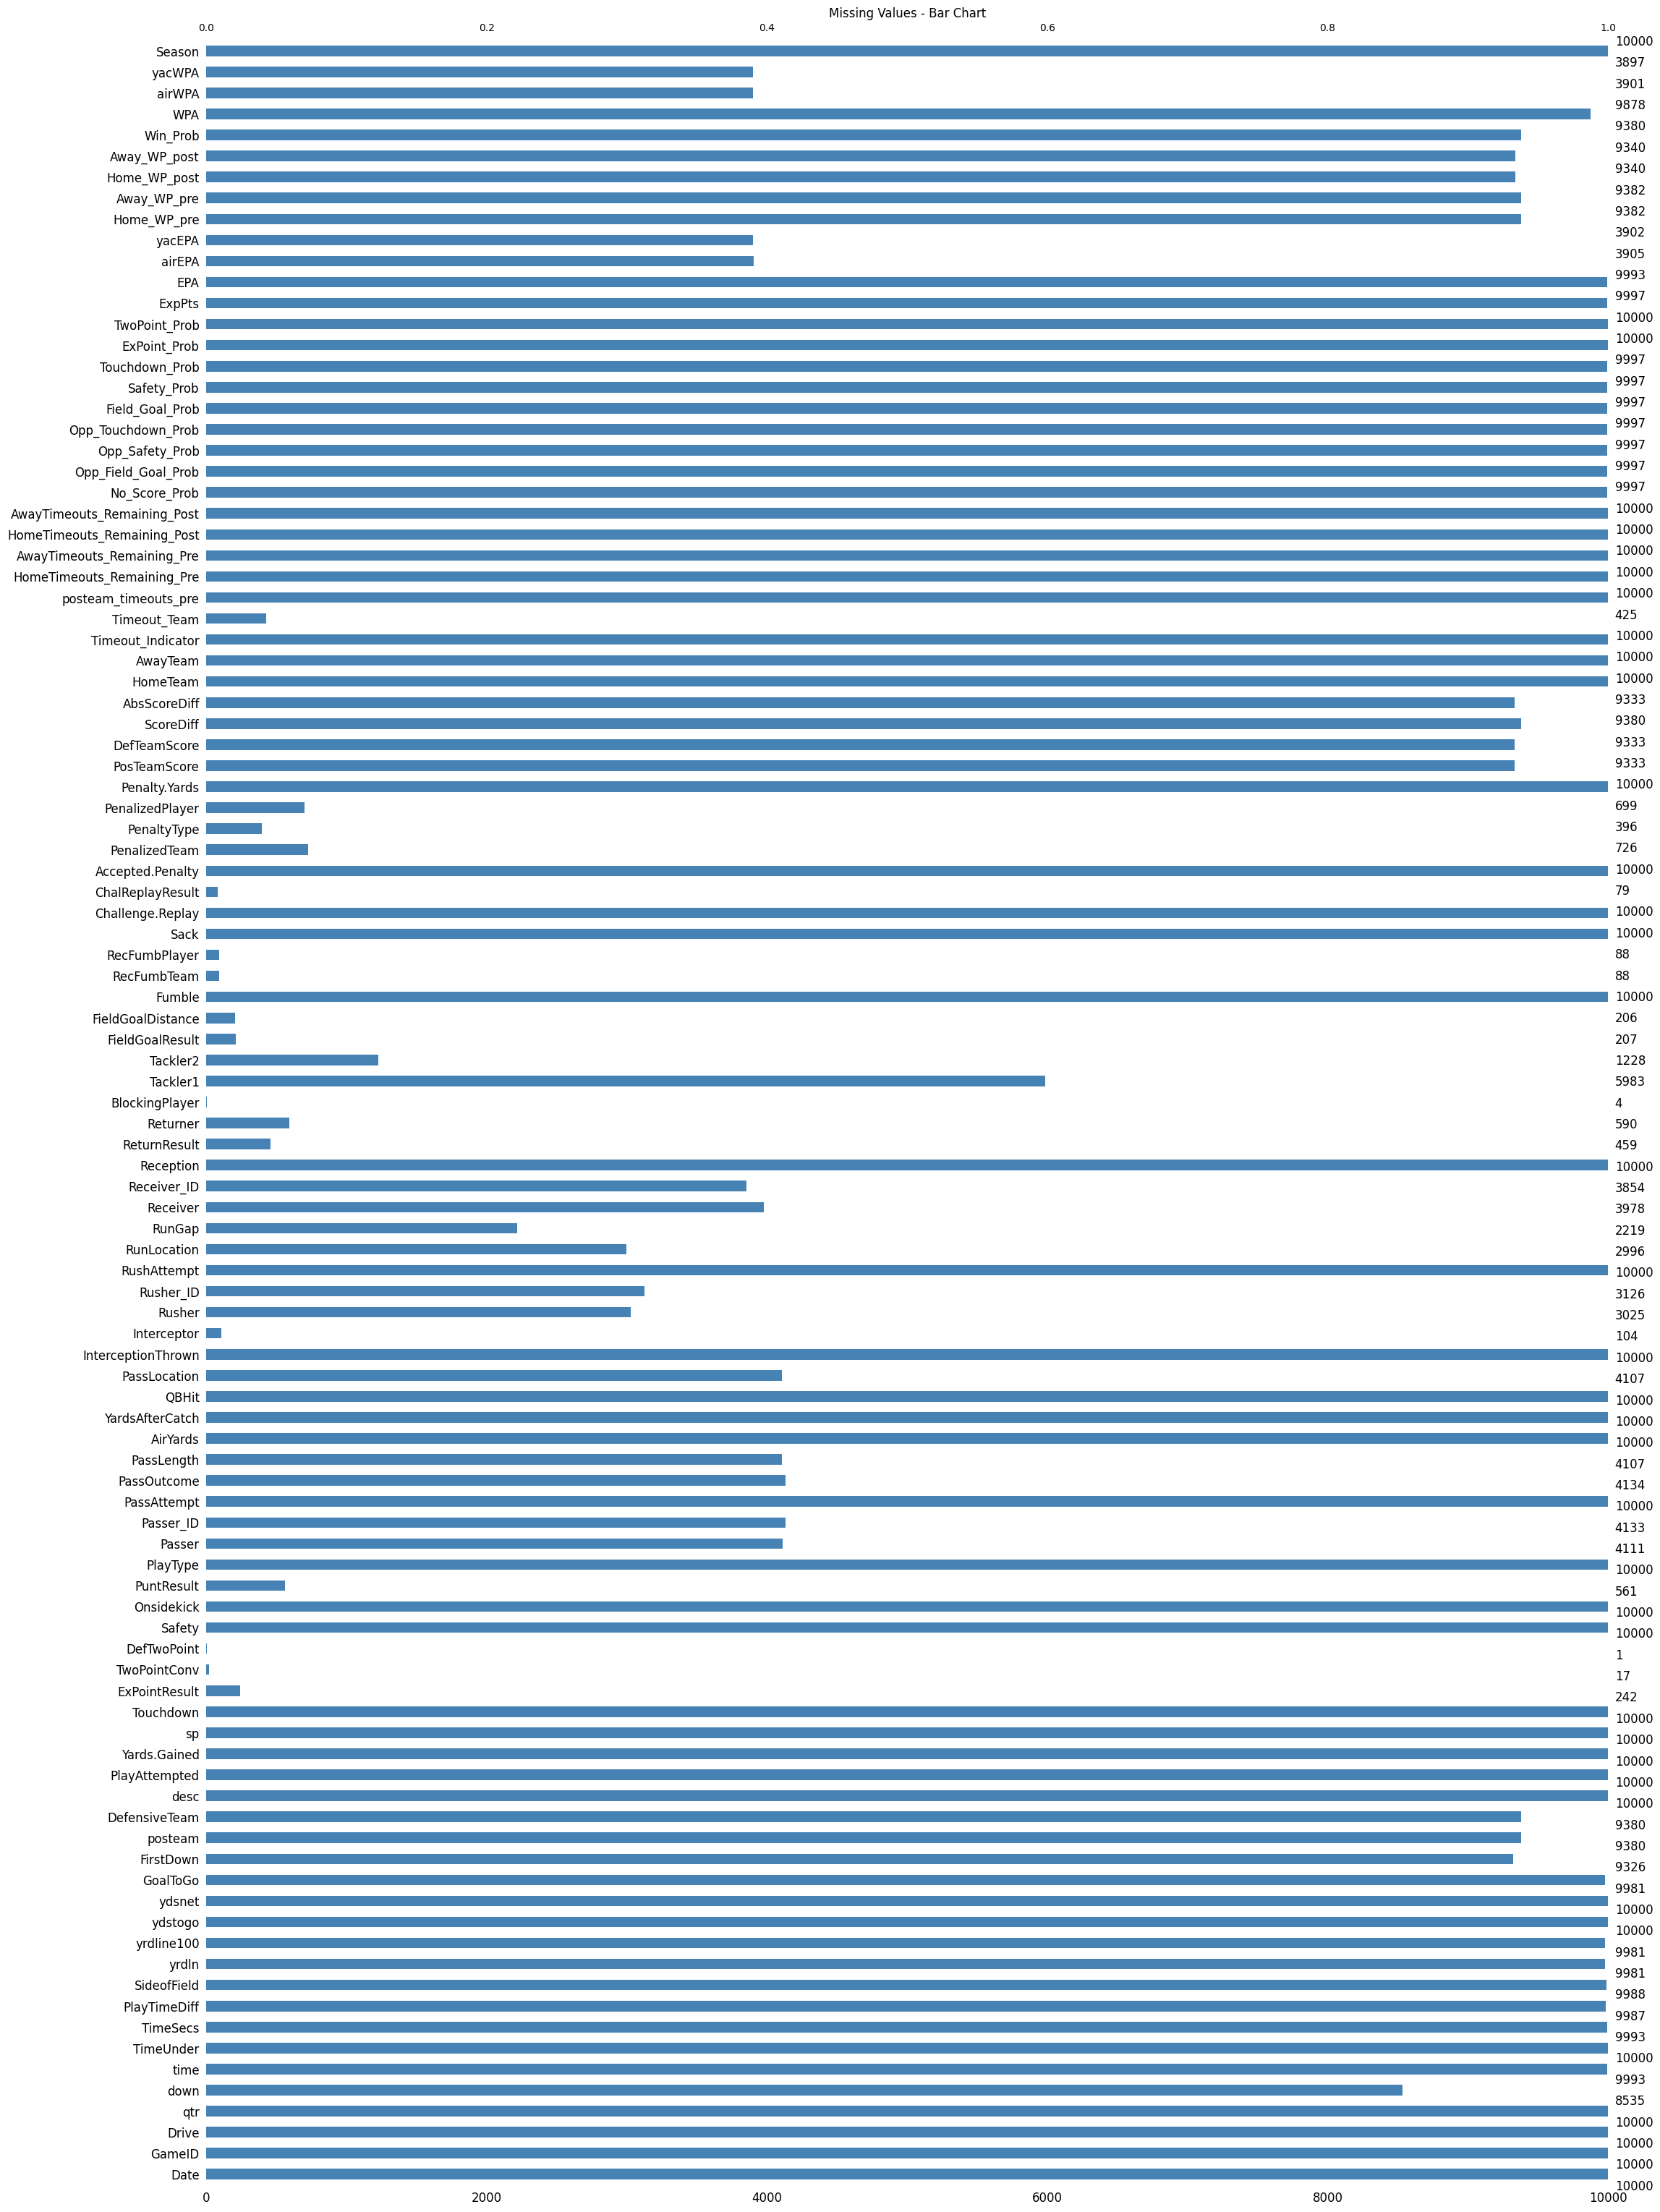

In [35]:
# Eksik değer görselleştirmeleri:eksik verileri sütun bazında çubuk grafiği olarak gösteriyor
plt.figure(figsize=(10, 5))
msno.bar(df, fontsize=12, color='steelblue')
plt.title('Missing Values - Bar Chart')
plt.show()




#Maximum Likelihood İmputasyonu ile Eksik Değer Doldurma





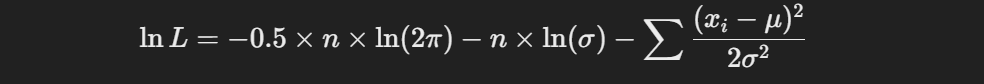

In [36]:
df_ml=df.copy()

 **  •	Süreç:**

* Rastgele çekilen örnek veri üzerinden ortalama (mu) ve standart sapma (sigma) değerleri, maksimum olabilirlik yöntemiyle (MLE) tahmin edilir.


*  Elde edilen mu ve sigma parametreleri kullanılarak, eksik değerler normal dağılımdan örneklenerek doldurulur.





In [37]:
# Maximum Likelihood (MLE) ile eksik veri doldurma
np.random.seed(42)
sample_data = np.random.normal(loc=5, scale=2, size=100)

def neg_log_likelihood(params, data):#fonksiyonu, normal dağılım için negatif log-likelihood fonksiyonunu hesaplıyor.
    mu, sigma = params[0], params[1]
    if sigma <= 0:
        return np.inf  # sigma negatif olamaz
    n = len(data)
    ll = -0.5 * n * np.log(2 * np.pi) - n * np.log(sigma) - np.sum((data - mu)**2) / (2 * sigma**2)
    return -ll

initial_params = [np.mean(sample_data), np.std(sample_data, ddof=0)]
result = minimize(neg_log_likelihood, initial_params, args=(sample_data,)) #fonksiyonuyla bu negatif log-likelihood’u minimize ederek mu ve sigma bulunuyor.
mu_MLE, sigma_MLE = result.x

print("MLE ile tahmin edilen mu:", mu_MLE)
print("MLE ile tahmin edilen sigma:", sigma_MLE)



MLE ile tahmin edilen mu: 4.792306965211812
MLE ile tahmin edilen sigma: 1.8072323532892591




  ** Eksik veriler MLE yöntemiyle tahmin edilen normal dağılım parametrelerine dayanarak doldurulur ve sonuç olarak temizlenmiş bir veri seti oluşturulmuş olur. Bu veri seti daha sonra analiz veya modelleme çalışmalarında kullanılmak üzere CSV dosyasına kaydedilir.**




> **impute_value **fonksiyonu, bir hücrede NaN (eksik) varsa, yukarıda MLE ile tahmin edilen mu_MLE ve sigma_MLE parametreli normal dağılımdan rastgele bir değer çekiyor ve o hücreye atıyor.




In [38]:
# Eksik değerleri doldurmak için fonksiyon
def impute_value(val):
    if pd.isna(val):
        return np.random.normal(mu_MLE, sigma_MLE)
    return val

# Tüm veri seti üzerinde Maximum Likelihood imputasyonunu (applymap) uyguluyoruz.
df_ml = df_ml.applymap(impute_value)

print("Maximum Likelihood imputasyon sonrası eksik değer sayısı:")
print(df_ml.isnull().sum())

# İmpute edilmiş veri setini kopyalayarak kaydediyoruz.
LikeHodd_veriSeti = df_ml.copy()
LikeHodd_veriSeti.to_csv("LikeHood.csv", index=False)

<ipython-input-38-b610d4a8062e>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_ml = df_ml.applymap(impute_value)


Maximum Likelihood imputasyon sonrası eksik değer sayısı:
Date        0
GameID      0
Drive       0
qtr         0
down        0
           ..
Win_Prob    0
WPA         0
airWPA      0
yacWPA      0
Season      0
Length: 102, dtype: int64


In [39]:
# Hedef değişkeni y olarak atıyoruz. Bu sütun, maç kazanma olasılığını 0 ile 1 arasında bir değer olarak temsil eder.
y_likehood = LikeHodd_veriSeti[['Win_Prob']]

# Özellikler: 'Win_Prob', 'Date', 'time' sütunları dışındaki tüm sütunlar seçilir.
X_likehood = LikeHodd_veriSeti.drop(columns=['Win_Prob', 'Date', 'time'])



**Bu işlem, modelin aşırı karmaşık veya gereksiz bilgi içeren sütunlardan etkilenmemesi için yapılır. **

In [40]:
# Kategorik sütunları belirliyoruz.
cat_cols = X_likehood.select_dtypes(include=['object']).columns.tolist()

# Benzersiz değer sayısı 100'den fazla olan sütunları seçiyoruz.
high_card_cols = [col for col in cat_cols if X_likehood[col].nunique() > 100]

# Yüksek kardinaliteli sütunları veri setinden çıkarıyoruz.
X_likehood = X_likehood.drop(columns=high_card_cols)


#MICE İle İmputation (Sadece Sayısal Sütunlar Üzerinde)



*   Bu kod parçası, eksik değerleri MICE benzeri bir yaklaşımla (IterativeImputer) doldurarak yalnızca sayısal sütunlardan oluşan bir veri seti oluşturur.
*  **IterativeImputer modülü,** eksik verileri diğer sütunlarla ilişkisini göz önüne alarak iteratif şekilde doldurmak için kullanılır (MICE metoduna benzer).


In [41]:
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer'ı etkinleştirir.
from sklearn.impute import IterativeImputer

# Sadece sayısal sütunları seçiyoruz.
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]

imputer = IterativeImputer(random_state=42)
df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=numeric_cols) #İmputer, df_numeric üzerindeki eksik verileri diğer sütunlarla ilişki kurarak doldurur.

print("\nMICE sonrası ilk 5 satır:")
print(df_numeric_imputed.head())

# İmpute edilmiş sayısal veri setini kopyalıyoruz.
Mice_veriSeti = df_numeric_imputed.copy()
Mice_veriSeti.to_csv("MİCE.csv", index=False)


MICE sonrası ilk 5 satır:
         GameID  Drive  qtr      down  TimeUnder  TimeSecs  PlayTimeDiff  \
0  2.011122e+09    7.0  2.0  2.000000       15.0    2700.0           0.0   
1  2.015122e+09   22.0  4.0  1.000000        2.0     109.0           0.0   
2  2.012111e+09   18.0  4.0  4.045154       15.0     849.0           5.0   
3  2.017100e+09    9.0  2.0  3.430444        1.0    1843.0           8.0   
4  2.017100e+09   14.0  3.0  1.000000       12.0    1573.0          39.0   

   yrdln  yrdline100  ydstogo  ...    yacEPA  Home_WP_pre  Away_WP_pre  \
0   21.0        79.0     23.0  ...  0.728057     0.310828     0.689172   
1   11.0        11.0     10.0  ... -0.427087     0.996070     0.003930   
2   35.0        35.0      0.0  ... -0.534975     0.000626     0.999374   
3   31.0        31.0      0.0  ... -0.680803     0.529394     0.470930   
4   44.0        56.0     10.0  ... -0.608736     0.053402     0.946598   

   Home_WP_post  Away_WP_post  Win_Prob       WPA    airWPA    yacWPA  

In [42]:
y_mice = Mice_veriSeti[['Win_Prob']]
X_Mice = Mice_veriSeti.drop(columns=['Win_Prob'])

# EM Algoritması ile eksik veri doldurma







* **Geçici Doldurma:** İlk olarak, eksik değerler sütun ortalamaları gibi basit yöntemlerle doldurulur.

## Model Eğitimi:
*   	Gaussian Mixture Model (GMM) kullanılarak, geçici doldurulmuş veriler üzerinden veri dağılımı modellenir.
* EM algoritması, verinin dağılım parametrelerini (örneğin, ortalama ve varyans) iteratif olarak günceller.

## Eksik Değerlerin İmputationu:
 Eğitilen GMM'den rastgele örnekler çekilerek, orijinal veri setindeki eksik değerler doldurulur.


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer

"""GaussianMixture: Gaussian Mixture Model (GMM) kullanarak verinin dağılımını modellemek için.
    SimpleImputer: İlk etapta, eksik değerleri sütun ortalamalarıyla doldurmak için kullanılır."""


# Sadece sayısal sütunları seçiyoruz.
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols].copy()

# İlk adım: eksik değerleri sütun ortalamalarıyla dolduruyoruz
imputer = SimpleImputer(strategy="mean")
data_imputed = imputer.fit_transform(df_numeric)

# Gaussian Mixture Model (tek bileşenli; temelde normal dağılım) ile modelleme
gmm = GaussianMixture(n_components=1, max_iter=50, random_state=42)
gmm.fit(data_imputed)

# Eksik Değerlerin Tespit Edilmesi ve GMM'den Örnekleyerek Doldurulması
missing_rows, missing_cols = np.where(np.isnan(df_numeric)) # df_numeric içerisinde hala eksik (NaN) değerlerin konumlarını tespit eder.
for row, col in zip(missing_rows, missing_cols):
    df_numeric.iloc[row, col] = gmm.sample(1)[0][0, col] #gmm.sample(1) kullanılarak, GMM modelinden ilgili sütun için yeni bir örnek değeri çekilir.
df_beklenti = pd.DataFrame(df_numeric)




In [44]:
# Hedef değişkeni y olarak atıyoruz.Bu sütun, maç kazanma olasılığını 0 ile 1 arasında bir değer olarak temsil eder.
y_EM = df_beklenti[['Win_Prob']]

# Özellikler (X): 'Win_Prob', 'Date', 'time' sütunları dışındaki tüm sütunlar
X_EM = df_beklenti.drop(columns=['Win_Prob'])


\


# Linner Model Eğitimi

In [45]:
def LineerModel(X, y, threshold=0.5):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   # Kategorik değişkenler için one-hot encoding
    X_train_enc = pd.get_dummies(X_train, drop_first=True)
    X_test_enc = pd.get_dummies(X_test, drop_first=True)
    X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

    # Linear Regression modelini eğitiyoruz.
    lr = LinearRegression()
    lr.fit(X_train_enc, y_train)
    y_pred = lr.predict(X_test_enc)

    # Regresyon metriklerini hesaplıyoruz.
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Regression Metrics:")
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R^2 Score:", r2)


    # Binary sınıflandırma değerlendirmesi
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_test_binary = (y_test.values >= threshold).astype(int)
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    print("\nConfusion Matrix:\n", cm)
    acc = accuracy_score(y_test_binary, y_pred_binary)
    print("Accuracy Score:", acc)
    print("\nClassification Report:\n", classification_report(y_test_binary, y_pred_binary))


    # Hem regresyon hem de sınıflandırma sonuçlarını döndürüyoruz.
    return lr


In [46]:
# Model eğitimi
print("\n--- Maximum Likelihood Model Eğitimi ---")
LineerModel(X_likehood, y_likehood)



--- Maximum Likelihood Model Eğitimi ---
Regression Metrics:
Mean Squared Error (MSE): 16.179314549300095
Mean Absolute Error (MAE): 0.288404049847858
R^2 Score: -11.939243148215292

Confusion Matrix:
 [[807 105]
 [119 969]]
Accuracy Score: 0.888

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       912
           1       0.90      0.89      0.90      1088

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



LinearRegression()

In [47]:
print("\n--- MICE Model Eğitimi ---")
LineerModel(X_Mice, y_mice)


--- MICE Model Eğitimi ---
Regression Metrics:
Mean Squared Error (MSE): 0.009028668429465536
Mean Absolute Error (MAE): 0.06115212944884111
R^2 Score: 0.8859663553100687

Confusion Matrix:
 [[972  64]
 [ 24 940]]
Accuracy Score: 0.956

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      1036
           1       0.94      0.98      0.96       964

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



LinearRegression()

In [48]:
print("\n--- EM Model Eğitimi ---")

LineerModel(X_EM, y_EM)



--- EM Model Eğitimi ---
Regression Metrics:
Mean Squared Error (MSE): 0.009110343803403295
Mean Absolute Error (MAE): 0.06194478706675693
R^2 Score: 0.8900430448589823

Confusion Matrix:
 [[ 850   62]
 [  24 1064]]
Accuracy Score: 0.957

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       912
           1       0.94      0.98      0.96      1088

    accuracy                           0.96      2000
   macro avg       0.96      0.95      0.96      2000
weighted avg       0.96      0.96      0.96      2000



LinearRegression()

#K-Means, Aykırı Değer Temizleme

Küme 1: 2105 veri noktası
Küme 2: 1717 veri noktası
Küme 3: 2441 veri noktası
Küme 4: 1728 veri noktası
Küme 5: 2009 veri noktası
İlk Küme Merkezleri: [[np.float64(0.0), np.float64(0.2562153602533639), np.float64(0.9024106169156159), np.float64(0.5216909131306017)], [np.float64(0.6806930693069307), np.float64(0.21549213744903806), np.float64(0.3373103958564555), np.float64(0.15923756916279963)], [np.float64(0.3028471937730438), np.float64(0.13641950020483348), np.float64(0.6508949942819426), np.float64(0.5214893586948857)], [np.float64(0.6682581018518519), np.float64(0.26543209876543117), np.float64(0.351502835804132), np.float64(0.8532059630676156)], [np.float64(0.3983325037332006), np.float64(0.8415463746474298), np.float64(0.5717283231746455), np.float64(0.4652639397837475)]]


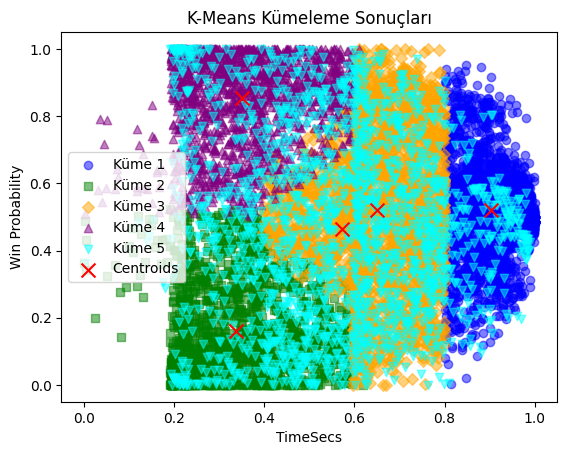

Küme 1: 1678 veri noktası
Küme 2: 1208 veri noktası
Küme 3: 1570 veri noktası
Küme 4: 1595 veri noktası
Küme 5: 2358 veri noktası
Aykırı Değer Temizlenmiş Küme Merkezleri: [[np.float64(0.668057210965435), np.float64(0.26181962653953017), np.float64(0.34522470917437925), np.float64(0.1399201671922435)], [np.float64(0.18274006622516556), np.float64(0.7588300220750468), np.float64(0.7489100069616753), np.float64(0.4753287852403526)], [np.float64(0.0), np.float64(0.1462845010615725), np.float64(0.9040020659146966), np.float64(0.5311159048504901)], [np.float64(0.6658307210031348), np.float64(0.3061650992685468), np.float64(0.3511043608311004), np.float64(0.8722444261662425)], [np.float64(0.3042832909245123), np.float64(0.13005371783997738), np.float64(0.6486336777097232), np.float64(0.5271461760622211)]]


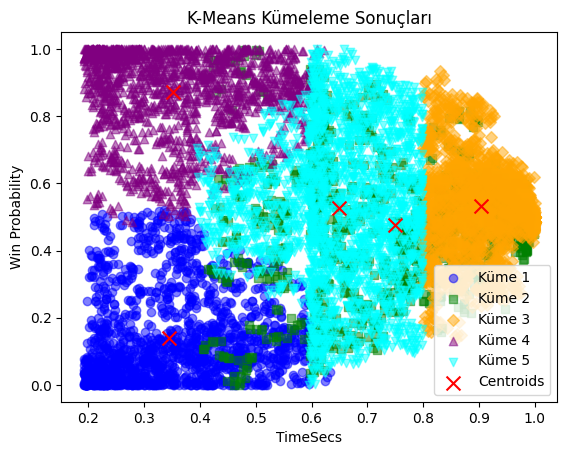

In [54]:
import random
import math
import csv
import matplotlib.pyplot as plt
import os
import numpy as np
import kagglehub
from sklearn.neighbors import NearestNeighbors
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer'ı etkinleştirir.
from sklearn.impute import IterativeImputer

# Kaggle veri setini indir
path = kagglehub.dataset_download("maxhorowitz/nflplaybyplay2009to2016")
filename = os.path.join(path, "NFL Play by Play 2009-2017 (v4).csv")

# Veri setini yükleyelim (10000 örnek ile sınırlı)
def load_data(filename, sample_size=10000):
    data = []
    with open(filename, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            try:
                # Gerekli sütunları alıp uygun tipte kaydedelim
                qtr = int(row['qtr'])
                down = int(row['down'])
                time_secs = float(row['TimeSecs'])
                win_prob = float(row['Win_Prob'])
                data.append([qtr, down, time_secs, win_prob])
            except ValueError:
                continue  # Hatalı satırları atla
    # Rastgele örnek seç
    data = random.sample(data, min(sample_size, len(data)))
    return data

 # MICE dönüşümünü uygulama (Eksik verileri doldur)
def apply_mice_imputation(data):
    # Veriyi numpy dizisine dönüştür
    data_np = np.array(data, dtype=float)

    # MICE (Multiple Imputation by Chained Equations) ile eksik verileri doldur
    imputer = IterativeImputer(max_iter=10, random_state=0)
    data_imputed = imputer.fit_transform(data_np)  # Veriyi doldur
    return data_imputed

# KNN ile aykırı değerleri tespit etme
def knn_outlier_removal(data, k=5, threshold=0.6):
    # Veriyi numpy array olarak dönüştür
    data_np = np.array(data)

    # 2D şekil sağlamak için, her veri satırını düzgün şekilde hizalayalım
    data_np = data_np.reshape(-1, len(data[0]))  # Veri kümesindeki her bir satır uzunluğu kadar

    # KNN modelini fit et
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data_np)
    distances, _ = nbrs.kneighbors(data_np)

    # En yakın komşuların ortalama mesafesi
    mean_distances = np.mean(distances[:, 1:], axis=1)  # İlk sütun kendisi olduğundan hariç tutulur
    threshold_value = np.mean(mean_distances) + threshold * np.std(mean_distances)

    # Aykırı olmayanları filtrele
    filtered_data = [data[i] for i in range(len(data)) if mean_distances[i] <= threshold_value]
    return filtered_data


# Min-Max Normalizasyonu
def normalize_data(data):
    min_vals = [min(col) for col in zip(*data)]
    max_vals = [max(col) for col in zip(*data)]
    normalized_data = [
        [(val - min_vals[i]) / (max_vals[i] - min_vals[i]) if max_vals[i] - min_vals[i] != 0 else 0
         for i, val in enumerate(row)]
        for row in data
    ]
    return normalized_data

# Öklid Mesafesi Hesaplama
def euclidean_distance(point1, point2):
    return math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))

# K-Means Kümeleme Algoritması
def k_means_clustering(data, k, max_iters=100):
    if k > len(data):
        k = len(data)  # Küme sayısını veri sayısına eşitle
        print(f"Veri kümesi büyüklüğünden dolayı k değeri {len(data)} olarak ayarlandı.")

    centroids = random.sample(data, k)
    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]

        # Her veri noktasını en yakın merkeze ata
        for point in data:
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            cluster_index = distances.index(min(distances))
            clusters[cluster_index].append(point)

        # Yeni küme merkezlerini hesaplayalım
        new_centroids = []
        for cluster in clusters:
            if cluster:
                new_centroid = [sum(dim) / len(cluster) for dim in zip(*cluster)]
            else:
                all_points = [point for cluster in clusters for point in cluster]
                max_dist_point = max(all_points, key=lambda p: sum(euclidean_distance(p, c) for c in centroids))
                new_centroid = max_dist_point
            new_centroids.append(new_centroid)

        # Eğer merkezler değişmezse algoritma durur
        if new_centroids == centroids:
            break
        centroids = new_centroids

    return clusters, centroids


# Kümeleme sonuçlarını görselleştirme
def plot_clusters(clusters, centroids):
    colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta']
    markers = ['o', 's', 'D', '^', 'v', '*']
    for i, cluster in enumerate(clusters):
        x_vals = [point[2] for point in cluster]
        y_vals = [point[3] for point in cluster]
        plt.scatter(x_vals, y_vals, color=colors[i % len(colors)], marker=markers[i % len(markers)], alpha=0.5, label=f'Küme {i+1}')

    centroid_x = [centroid[2] for centroid in centroids]
    centroid_y = [centroid[3] for centroid in centroids]
    plt.scatter(centroid_x, centroid_y, color='red', marker='x', s=100, label='Centroids')

    plt.xlabel('TimeSecs')
    plt.ylabel('Win Probability')
    plt.title('K-Means Kümeleme Sonuçları')
    plt.legend()
    plt.show()


# Ana Program
data = load_data(filename, sample_size=10000)

# 1) MICE ile eksik değer doldurma
data_imputed = apply_mice_imputation(data)

# 2) Normalizasyon (MICE sonrası)
data_normalized = normalize_data(data_imputed)

# 3) K-Means kümeleme (normalleştirilmiş veri)
k = 5
clusters, centroids = k_means_clustering(data_normalized, k)

# İlk kümeleme sonuçlarını yazdır
for i, cluster in enumerate(clusters):
    print(f'Küme {i + 1}: {len(cluster)} veri noktası')
print("İlk Küme Merkezleri:", centroids)

# İlk kümeleme görselleştirme
plot_clusters(clusters, centroids)

# 4) Aykırı değer temizleme (normalize edilmiş veri üzerinde)
data_knn_filtered = knn_outlier_removal(data_normalized, k=5, threshold=0.6)

# 5) Tekrar K-Means (aykırı değerler atıldıktan sonra)
clusters, centroids = k_means_clustering(data_knn_filtered, k)

# İkinci (temizlenmiş) kümeleme sonuçlarını yazdır
for i, cluster in enumerate(clusters):
    print(f'Küme {i + 1}: {len(cluster)} veri noktası')
print("Aykırı Değer Temizlenmiş Küme Merkezleri:", centroids)

# İkinci kümeleme görselleştirme
plot_clusters(clusters, centroids)

